In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.helper import npa_to_seq
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots
import getdist

sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery

# Importing fiducial data

In [2]:
image_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image")
data_dc2 = image_cat.get_quantities(
    ["redshift_true", "halo_mass"],
    filters=[
        f"redshift_true > {0.0}",
        f"redshift_true < {1.2}",
        f"halo_mass > {10**13}",
        f"halo_mass < {10**16}",
        f"is_central == {True}", 
    ],
)

table_halos = Table(data_dc2)
table_halos['lnM'] = np.log(table_halos['halo_mass'])

# Cluster Mass-Richness

In [3]:
cluster_m = Nc.ClusterMassAscaso(lnRichness_min = np.log(5.0) ,lnRichness_max = 6.0)
cluster_m.set_enable_rejection(True)

cluster_m_nocut = Nc.ClusterMassAscaso(lnRichness_min = 0.0 ,lnRichness_max = 6.0)

# Data from CosmoDC2 RedMapper match

In [4]:
rng = Ncm.RNG.seeded_new(None, 13)

lnM_v = Ncm.Vector.new_array(npa_to_seq(table_halos['lnM']))
z_v = Ncm.Vector.new_array(npa_to_seq(table_halos['redshift_true']))
rich_v = Ncm.Vector.new(len(table_halos['lnM']))
rich_v.set_zero()

dmr = Nc.DataClusterMassRich.new()
dmr.set_data(lnM_v, z_v, rich_v)

mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()
mset_nocut = Ncm.MSet.new_array([cluster_m_nocut])
mset_nocut.prepare_fparam_map()

# MC

## $\lambda_{cut}= 5$

In [5]:
cut = np.log(5.0)
cluster_m.param_set_by_name("cut", cut)
cluster_m.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.04})
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.053})
cluster_m.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.2138})
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.5003})
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.02672})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.1495})

'''
cluster_m_nocut.param_set_by_name("cut", -1e20)
cluster_m_nocut.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.04})
cluster_m_nocut.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.053})
cluster_m_nocut.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.2138})
cluster_m_nocut.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.5003})
cluster_m_nocut.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.02672})
cluster_m_nocut.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.1495})
'''

dmr.resample(mset,rng)
print(dmr.peek_lnR().len())

'''
dmr_nocut = Nc.DataClusterMassRich.new()
dmr_nocut.set_data(dmr.peek_lnM(), dmr.peek_z(), dmr.peek_lnR())

dset_nocut = Ncm.Dataset.new()
dset_nocut.append_data(dmr_nocut)
lh_nocut = Ncm.Likelihood.new(dset_nocut)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_nocut, mset_nocut, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher()
fit.log_covar()
'''

45208


'\ndmr_nocut = Nc.DataClusterMassRich.new()\ndmr_nocut.set_data(dmr.peek_lnM(), dmr.peek_z(), dmr.peek_lnR())\n\ndset_nocut = Ncm.Dataset.new()\ndset_nocut.append_data(dmr_nocut)\nlh_nocut = Ncm.Likelihood.new(dset_nocut)\n\nfit = Ncm.Fit.factory(\n    Ncm.FitType.NLOPT, "ln-neldermead", lh_nocut, mset_nocut, Ncm.FitGradType.NUMDIFF_CENTRAL\n)\nfit.log_info()\nfit.run(Ncm.FitRunMsgs.SIMPLE)\nfit.obs_fisher()\nfit.log_covar()\n'

In [6]:
mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_5.fits")

fitmc.start_run()
fitmc.run(10000)
fitmc.end_run()
fitmc.mean_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 10000 realizations, will start at 10001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 10000


mset_nocut = Ncm.MSet.new_array([cluster_m_nocut])
mset_nocut.prepare_fparam_map()

dset_nocut = Ncm.Dataset.new()
dset_nocut.append_data(dmr)
lh_nocut = Ncm.Likelihood.new(dset_nocut)

fit_nocut = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_nocut, mset_nocut, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc_nocut = Ncm.FitMC.new(fit_nocut, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.FULL)
fitmc_nocut.set_fiducial(mset)
fitmc_nocut.set_nthreads(2)
fitmc_nocut.set_data_file("mc_nocut_5.fits")

fitmc_nocut.start_run()
fitmc_nocut.run(10000)
fitmc_nocut.end_run()
fitmc_nocut.mean_covar()

## $\lambda_{cut}= 10$

In [7]:
cut = np.log(10.0)
cluster_m.param_set_by_name("cut", cut)
cluster_m.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.0472 })
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.0367})
cluster_m.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.32909})
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.5153})
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.00027498})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.027672})
                          
dmr.resample(mset,rng)
print(dmr.peek_lnR().len())

16006


In [8]:
mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_10.fits")

fitmc.start_run()
fitmc.run(10000)
fitmc.end_run()
fitmc.mean_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 10000 realizations, will start at 10001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 10000


In [9]:
fit_10  = Table((fits.open("mc_cut_10.fits")[1].data))
print(fit_10['NcmFit:m2lnL'].min())
print(fit_10['NcmFit:m2lnL'].max())
p = len(fit_10[fit_10['NcmFit:m2lnL']>= -65169]['NcmFit:m2lnL'])/len(fit_10['NcmFit:m2lnL'])
p

-27188.734374514897
-25251.378953796386


1.0

## $\lambda_{cut}= 15$

In [10]:
cut = np.log(15.0)
cluster_m.param_set_by_name("cut", cut)
cluster_m.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  4.0162})
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.95916})
cluster_m.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.32645  })
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.51648 })
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.015719})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":0.023168 })
                         
dmr.resample(mset,rng)
print(dmr.peek_lnR().len())

9314


In [11]:
mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_15.fits")

fitmc.start_run()
fitmc.run(10000)
fitmc.end_run()
fitmc.mean_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 10000 realizations, will start at 10001-th realization.


## $\lambda_{cut}= 20$

In [12]:
cut = np.log(20.0)
cluster_m.param_set_by_name("cut", cut)
cluster_m.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.0138 })
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.91105 })
cluster_m.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":  0.38541 })
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.51176})
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.028479})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":0.043325})

                          
dmr.resample(mset,rng)
print(dmr.peek_lnR().len())

5873


In [13]:
mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_20.fits")

fitmc.start_run()
fitmc.run(10000)
fitmc.end_run()
fitmc.mean_covar()

#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 10000
# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 10000 realizations, will start at 10001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 10000


## $\lambda_{cut}= 30$

In [14]:
cut = np.log(30.0)
cluster_m.param_set_by_name("cut", cut)
cluster_m.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.0765  })
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.90136})
cluster_m.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":   0.50788 })
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":0.48338})
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.031781})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.014054})
'''            
cluster_m_nocut.param_set_by_name("cut", 0.0)
cluster_m_nocut.param_set_desc("mup0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.04})
cluster_m_nocut.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.053})
cluster_m_nocut.param_set_desc("mup2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.2138})
cluster_m_nocut.param_set_desc("sigmap0",{ "lower-bound": 0.0,"upper-bound": 20.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.5003})
cluster_m_nocut.param_set_desc("sigmap1",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.02672})
cluster_m_nocut.param_set_desc("sigmap2",{ "lower-bound": -2.0,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.1495})
'''
dmr.resample(mset,rng)
print(dmr.peek_lnR().len())

2742


In [15]:
mset = Ncm.MSet.new_array([cluster_m])
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("mc_cut_30.fits")

fitmc.start_run()
fitmc.run(10000)
fitmc.end_run()
fitmc.mean_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 10000 realizations, will start at 10001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 10000


mset_nocut = Ncm.MSet.new_array([cluster_m_nocut])
mset_nocut.prepare_fparam_map()

dset_nocut = Ncm.Dataset.new()
dset_nocut.append_data(dmr)
lh_nocut = Ncm.Likelihood.new(dset_nocut)

fit_nocut = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_nocut, mset_nocut, Ncm.FitGradType.NUMDIFF_CENTRAL
)

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

fitmc_nocut = Ncm.FitMC.new(fit_nocut, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc_nocut.set_fiducial(mset)
fitmc_nocut.set_nthreads(2)
fitmc_nocut.set_data_file("mc_nocut_30.fits")

fitmc_nocut.start_run()
fitmc_nocut.run(10000)
fitmc_nocut.end_run()
fitmc_nocut.mean_covar()

# Corner plot

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


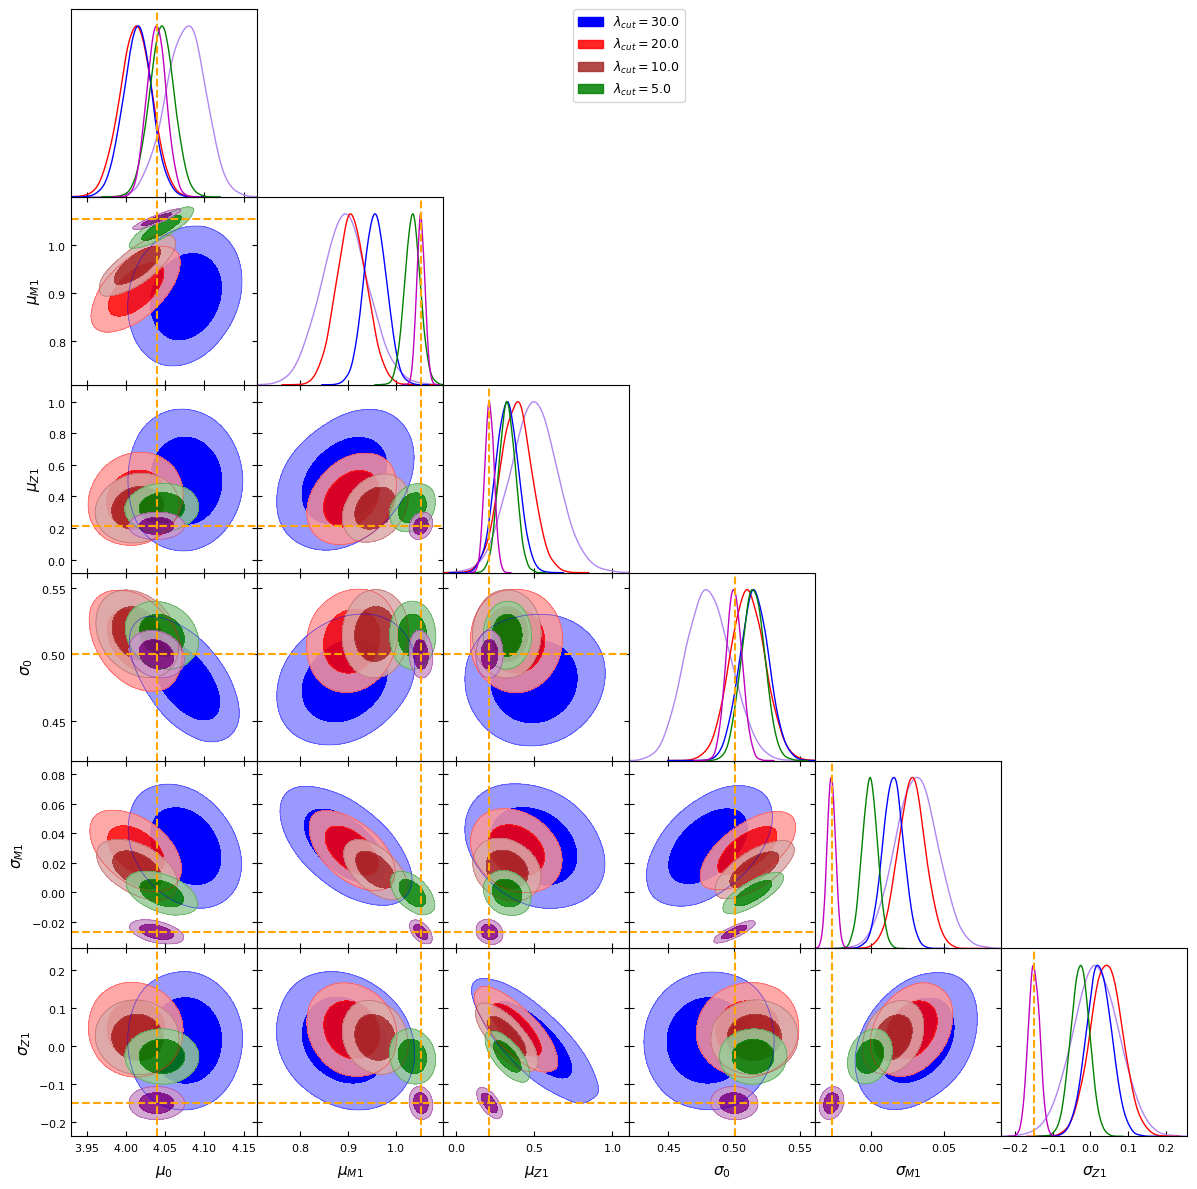

In [20]:
data_fit_5  = (pd.DataFrame(fits.open("mc_cut_5.fits")[1].data).iloc[:, 1:7].T)
data_fit_10 = (pd.DataFrame(fits.open("mc_cut_10.fits")[1].data).iloc[:, 1:7].T)
data_fit_15 = (pd.DataFrame(fits.open("mc_cut_15.fits")[1].data).iloc[:, 1:7].T)
data_fit_20 = (pd.DataFrame(fits.open("mc_cut_20.fits")[1].data).iloc[:, 1:7].T)
data_fit_30 = (pd.DataFrame(fits.open("mc_cut_30.fits")[1].data).iloc[:, 1:7].T)

data_fit_void_5  = np.array(data_fit_5)
data_fit_void_10 = np.array(data_fit_10)
data_fit_void_15 = np.array(data_fit_15)
data_fit_void_20 = np.array(data_fit_20)
data_fit_void_30 = np.array(data_fit_30)

data_fit = []
for item in data_fit_void_5:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

data_fit_2 = []
for item in data_fit_void_10:
    arr = np.array(item)
    data_fit_2.append(np.asarray(arr.tolist()))

data_fit_3 = []
for item in data_fit_void_15:
    arr = np.array(item)
    data_fit_3.append(np.asarray(arr.tolist()))

data_fit_4 = []
for item in data_fit_void_20:
    arr = np.array(item)
    data_fit_4.append(np.asarray(arr.tolist()))

data_fit_5 = []
for item in data_fit_void_30:
    arr = np.array(item)
    data_fit_5.append(np.asarray(arr.tolist()))


names = ['1','2','3','4','5','6',]
labels = [r"\mu_0", r"\mu_{M1}" ,r"\mu_{Z1}",r"\sigma_0", r"\sigma_{M1}", r"\sigma_{Z1}"]

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples_5  = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples_10 = MCSamples(samples=data_fit_2, names=names, labels=labels, settings=settings)
samples_15 = MCSamples(samples=data_fit_3, names=names, labels=labels, settings=settings)
samples_20 = MCSamples(samples=data_fit_4, names=names, labels=labels, settings=settings)
samples_30 = MCSamples(samples=data_fit_5, names=names, labels=labels, settings=settings)

bf = [4.04, 1.053, 0.2138,  0.5003, -0.02672, -0.1495]

samples_5.removeBurn(0.0)
samples_10.removeBurn(0.0)
samples_10.removeBurn(0.0)
samples_20.removeBurn(0.0)
samples_30.removeBurn(0.0)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples_30, samples_20, samples_15, samples_10, samples_5],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["blue" , "red", "brown","green", "purple"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        r"$\lambda_{cut} =30.0$",r"$\lambda_{cut} =20.0$",r"$\lambda_{cut} =10.0$",r"$\lambda_{cut} =5.0$"
    ],
)


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="orange" ,linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="orange", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="orange", linestyle="--")


plt.savefig("mc_corner_plot.png")
plt.show()

# Goodness of fit test

In [21]:
fit_5  = Table((fits.open("mc_cut_5.fits")[1].data))
print('p(\u03BB>5)=%.5f' % (len(fit_5[fit_5['NcmFit:m2lnL']>= -65901.538 ]['NcmFit:m2lnL'])/len(fit_5['NcmFit:m2lnL'])))

fit_10  = Table((fits.open("mc_cut_10.fits")[1].data))
print('p(\u03BB>10)=%.5f' % (len(fit_10[fit_10['NcmFit:m2lnL']>= -22386  ]['NcmFit:m2lnL'])/len(fit_10['NcmFit:m2lnL'])))

fit_15  = Table((fits.open("mc_cut_15.fits")[1].data))
print('p(\u03BB>10)=%.5f' % (len(fit_15[fit_15['NcmFit:m2lnL']>= -11434.0495270926 ]['NcmFit:m2lnL'])/len(fit_15['NcmFit:m2lnL'])))

fit_20  = Table((fits.open("mc_cut_20.fits")[1].data))
print('p(\u03BB>20)=%.5f' % (len(fit_20[fit_20['NcmFit:m2lnL']>= -7534.9 ]['NcmFit:m2lnL'])/len(fit_20['NcmFit:m2lnL'])))

fit_30  = Table((fits.open("mc_cut_30.fits")[1].data))
print('p(\u03BB>30)=%.5f' % (len(fit_30[fit_30['NcmFit:m2lnL']>= -3902.7  ]['NcmFit:m2lnL'])/len(fit_30['NcmFit:m2lnL'])))

p(λ>5)=0.96250
p(λ>10)=0.00000
p(λ>10)=0.00000
p(λ>20)=0.00000
p(λ>30)=0.00000


In [22]:
print(fit_5['NcmFit:m2lnL'].min())
print(fit_5['NcmFit:m2lnL'].max())

print(fit_10['NcmFit:m2lnL'].min())
print(fit_10['NcmFit:m2lnL'].max())

print(fit_15['NcmFit:m2lnL'].min())
print(fit_15['NcmFit:m2lnL'].max())

print(fit_20['NcmFit:m2lnL'].min())
print(fit_20['NcmFit:m2lnL'].max())

print(fit_30['NcmFit:m2lnL'].min())
print(fit_30['NcmFit:m2lnL'].max())

-66759.54975137708
-63598.010029304234
-27188.734374514897
-25251.378953796386
-17385.664133203234
-15896.848967880349
-12082.758778698235
-10676.228248502084
-6225.815344406875
-5242.309089440431


In [19]:
fit_5  = Table((fits.open("mc_cut_5.fits")[1].data))
print('p(\u03BB>5)=%.5f' % (len(fit_5[fit_5['NcmFit:m2lnL']>= -65999 ]['NcmFit:m2lnL'])/len(fit_5['NcmFit:m2lnL'])))

p(λ>5)=0.97790
